---
title: "Unsupervised Learning"
format:
    html: 
        code-fold: false
---

Unsupervised learning is a branch of machine learning that works with data that does not have predefined labels. The goal is to identify underlying patterns or clusters, but since there are no explicit labels, the algorithm must discover these on its own. Two key components of unsupervised learning are dimensionality reduction and clustering, these are effective methods for reducing high-dimensional data. In this case, we will apply these algorithms to our data to identify relationships between different features and reduce the complexity of the data, with the goal of creating a parsimonious model.

## Part 1: Dimensionality Reduction

### PCA 

Principal Component Analysis (PCA) is an unsupervised learning technique used for dimensionality reduction. It applies linear transformations to find the most important features, or principal components. It is a great technique to use if you have many dimensions and need a way to visualize them in 2 dimensions. It is also a good preprocessing technique to apple before supervised learning algorithms. The goal of PCA is to capture as much of the variance contained in the data as possible but in reduced dimensions. An important hyperparameter to tune is n_components, which specifies how many prinicipal components you want to retain.

In this case, we will apply PCA to our socioeconomic features to explore potential patterns and reduce the dimensionality of the data.

In [347]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, SpectralClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage

In [287]:
df = pd.read_csv('../../data/processed-data/processed_df.csv', index_col=None)

I will specify a subset of the socioeconomic factors in our dataframe

In [288]:
econ_subset = df[["Percent HRA Eligible",
    "Percent in Temp Housing",
    "Percent Overage / Undercredited",
    "Economic Need Index",
    'Percent No High School (25+)',
    "Percent Bachelor's Degree or Higher (25+)",
    'Percent Language Other Than English at Home',
    'Percent Population with Disabilities',
    'Percent Foreign-Born Population',
    'Percent Households with Broadband Internet',
    'Median Household Income',
    'Percent Households on SNAP/Food Stamps', 'dropout_rate','Percent of Students Chronically Absent','Metric Value - College Persistence']]

In [289]:
df_clean = df.drop(columns=['DBN','zip code','School Name','Borough'],axis=1)

PCA is sensitive to variance in features of the dataset, so we need to make sure that all our features are on the same scale, we can achieve this using sklean StandardScaler. In addition, we also want to take the log of dropout rate so that it is normally distributed.

In [341]:
dropout_rate = np.log(econ_subset['dropout_rate']+1) 

X_features = econ_subset.drop(columns=['Percent of Students Chronically Absent','dropout_rate','Metric Value - College Persistence'], axis=1)

# Scale the features
X_scaled = scaler.fit_transform(X_features)

Now we can fit our PCA and visualize the first two components

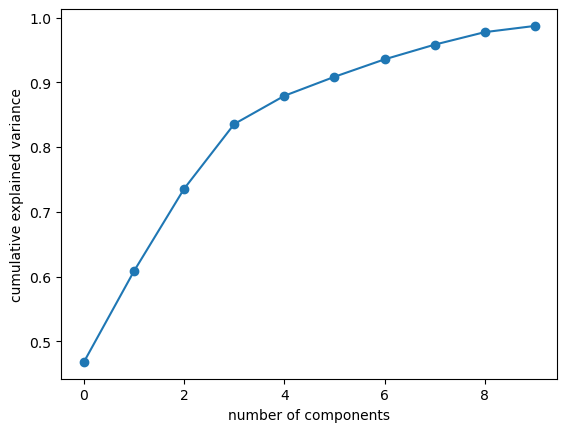

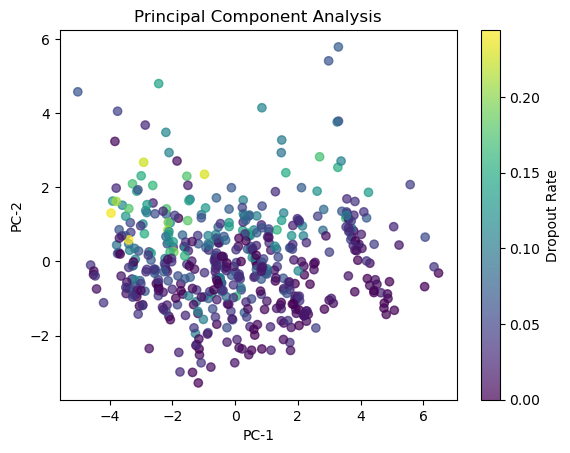

In [342]:
pca = PCA(n_components=10) 
X_pca = pca.fit_transform(X_scaled)

plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel("number of components")
plt.ylabel("cumulative explained variance")
plt.show()

#visualize the first two components
plt.scatter(X_pca[:,0], X_pca[:,1], c=dropout_rate, cmap='viridis', alpha=0.7)
plt.xlabel('PC-1')
plt.ylabel('PC-2')
plt.title('Principal Component Analysis')
plt.colorbar(label='Dropout Rate')

plt.show()

In [292]:
pca = PCA(n_components=3) 
X_pca = pca.fit_transform(X_scaled)

**Results:** From the first plot, we can visualize the the optimal number of components, by understanding the cumulative variance explained by additional components. According to this graph, it looks like 3 components is the optimal amount. After 3, the additional variance we are explaining is diminishing. The first two components explain about 70% of the varaince. While distinct clusters are not evident from the first two principal components, we are able to observe that schools with higher dropout rates tend to be positioned towards the top of the plot, while schools with lower dropout rates are located towards the bottom. This suggests a relationship between the principal components and dropout rates, even if the clusters are not clearly defined. This may indicate that we need to use a non-linear algorithm to find better relationships in our data. Next, we can try t-SNE to see if more distinct relationships emerge.

### t-SNE

t-distributed Stochastic Neighbor Embedding (t-SNE) is an unsupervised learning technique used for dimensionality reduction. It is effective for high-dimensional data and is preferred over linear methods like PCA when the data has non-linear relationships. It is a great tool for visualizing high dimensional data in 2D. The important hyperparameter here is perplexity, which controls the balance between local and global structure. At a high preplexity, t-SNE preseves global structure and results in more generalized clusters, while a lower perplexity emphasizes local structure and may be able to identify smaller distinct patterns. 

In this analysis, we will apply t-SNE to the entire dataset to explore how its clustering behavior can help visualize and understand the relationship between school and socioeconomic characteristics and college persistence.

In [293]:
#specify target that we will color graph by
college_persistence = df_clean['Metric Value - College Persistence']

# drop target column
X_features = df_clean.drop(['Metric Value - College Persistence'], axis=1)

# scale
X_scaled = scaler.fit_transform(df_clean)

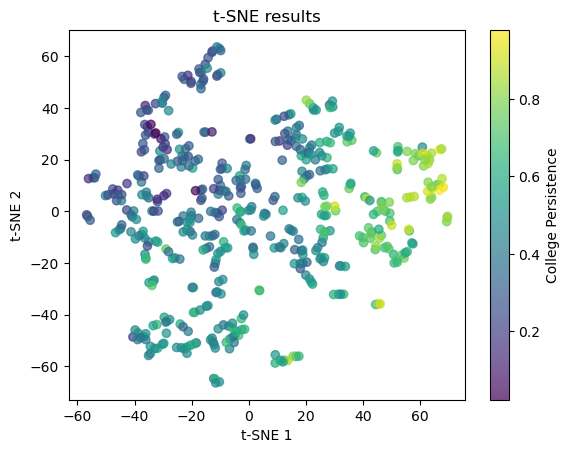

In [294]:
tsne = TSNE(n_components=2, perplexity=5)
X_tsne = tsne.fit_transform(X_scaled)

plt.scatter(X_tsne[:,0], X_tsne[:,1], c=college_persistence, cmap='viridis', alpha=0.7)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE results')
plt.colorbar(label='College Persistence')
plt.show()

We can also try a higher perplexity value, which focuses more on global structure rather than local structure

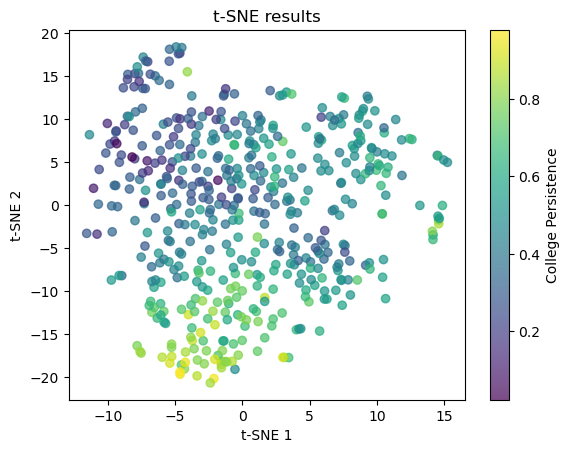

In [305]:
tsne = TSNE(n_components=2, perplexity=50)
X_tsne = tsne.fit_transform(X_scaled)

plt.scatter(X_tsne[:,0], X_tsne[:,1], c=college_persistence, cmap='viridis', alpha=0.7)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE results')
plt.colorbar(label='College Persistence')
plt.show()

**Results:** Although clearly defined and separable clusters are not present, at a low perplexity, we observe some distinct groupings of schools represented by lighter green and yellow dots, indicating that these schools have high college persistence. Conversely, darker purple clusters represent schools with lower college persistence. In the second graph, where the perplexity is set to 50, the clusters are less clearly separable. However, a noticeable pattern emerges, with high college persistence schools appearing towards the bottom and those with lower college persistence positioned towards the top. From this, we can conclude that t-SNE is able to uncover certain patterns in the data, helping to differentiate schools with varying levels of college persistence, even if the clusters are not perfectly defined.

#### PCA vs. t-SNE 

Both of these dimensionality reduction techniques are useful for reducing and visualizing high dimensional data. PCA is preferred for data with linear relationships because it is able to capture the maximum variance through few principal components. On the other hand, t-SNE is better for visualizing non-linear relationships. Depending on the perplexity, t-SNE may preserve local structure at low values and be able to uncover small clusters and relationships. However, this can be tricky if you are interested in interpretting it at the global level. In this case, using t-SNE with a low perplexity successfully grouped schools with similar outcomes, uncovering relationships that were less apparent in both PCA and t-SNE with higher perplexity. Given the small dataset, it appears that t-SNE was able to detect meaningful patterns where larger clusters were not present, revealing some of the underlying relationships between the schools.

### K-means Clustering

K-means is an unsupervised learning technique used for clustering. The goal is to group data points into distinct clusters. It does this by assigning each point to the nearest cluster center with the goal of minimizing the within-cluster variance.

To determine the optimal number of clusters, we can use the elbow method. The elbow method involved plotting the inertia and looking for the "elbow" of the graph, where the reduction in intertia starts to slow down. This is an important way to choose an optimal number of clusters becasue after this point, there is diminishing returns in reducing intertia and adding more clusters.

The goal of K-means clustering is:
1. Maximize inter-cluster distance: distance between clusters, high distance means high separation
2. Minimize intra-cluster distance: distance of points in cluster to the center, low distance means high cohesion.

We can evaluate our clusters with a silhouette score. A higher score indicates more well defined clusters.

We are going to perform K-means clustering on our data of socioeconomic factors that we reduced with PCA.



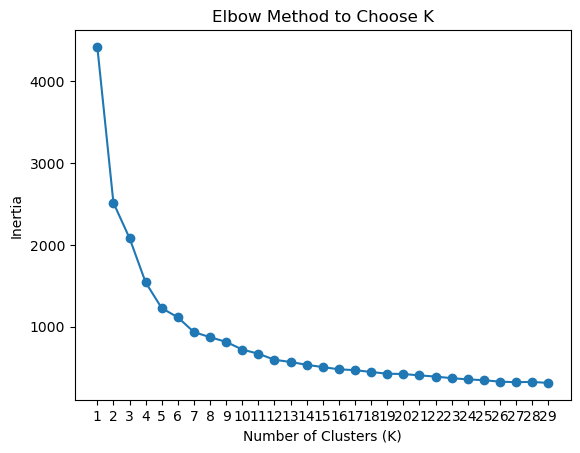

In [306]:
inertia = []
k_values = range(1, 30)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

plt.plot(k_values, inertia, marker='o')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.title("Elbow Method to Choose K")
plt.xticks(k_values)
plt.show()

We can see that the optimal number of clusters is about 4.

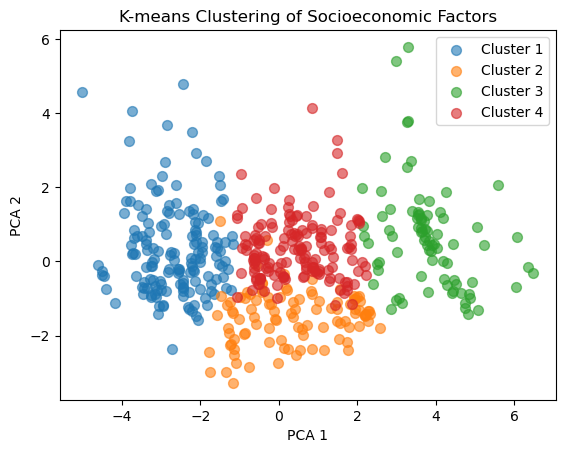

In [312]:
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters)
econ_clusters = kmeans.fit_predict(X_pca)

for cluster in range(n_clusters):
    plt.scatter(X_pca[econ_clusters == cluster, 0], X_pca[econ_clusters == cluster, 1],
        label=f"Cluster {cluster + 1}", s=50, alpha=0.6)

plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("K-means Clustering of Socioeconomic Factors")
plt.legend()
plt.show()

We can use the k-means cluster labels to view the means of each variable in our clusters and gauge the clustering performance

In [313]:
econ_df = econ_subset.copy()
econ_df['Cluster'] = kmeans.labels_

clusters = econ_df.groupby('Cluster').mean()
clusters.round(2)


,Percent HRA Eligible,Percent in Temp Housing,Percent Overage / Undercredited,Economic Need Index,Percent No High School (25+),Percent Bachelor's Degree or Higher (25+),Percent Language Other Than English at Home,Percent Population with Disabilities,Percent Foreign-Born Population,Percent Households with Broadband Internet,Median Household Income,Percent Households on SNAP/Food Stamps,dropout_rate,Percent of Students Chronically Absent,Metric Value - College Persistence
Cluster,,,,,,,,,,,,,,,
0,0.81,0.18,0.07,0.75,0.15,0.21,0.60,0.16,0.34,0.81,41433.45,0.40,0.07,0.44,0.41
1,0.56,0.07,0.03,0.64,0.10,0.39,0.58,0.11,0.46,0.88,76731.99,0.19,0.03,0.32,0.64
2,0.62,0.11,0.05,0.69,0.02,0.78,0.25,0.08,0.23,0.94,154196.88,0.06,0.04,0.43,0.54
3,0.73,0.13,0.06,0.80,0.07,0.38,0.36,0.11,0.32,0.87,77204.32,0.20,0.06,0.45,0.43


In [316]:
print(f'Silhouette Score: {silhouette_score(X_pca, kmeans.labels_)}')

Silhouette Score: 0.3276664537712163


**Results:** Taking a closer look at the clusters, cluster 0 stands out with the highest dropout rate, highest percent of student who are chronically absent, and lowest college persistence rate. The cluster is also associated with several socioeconomic challenges, including the highest percentage of students elgibile for public assistance from the NYC Human Resources Administration (HRA) [@NYCPublicSchoolsInfoHub_2024], a high Economic Need Index, the lowest percentage of people with a Bachelor's degree or higher, highest percentage of individuals with disabilities, lowest median household income, and highest percentage of households on food stamps.

It is evident that the K-means clustering is able to effectively find groupings of schools based on socioeconomic factors. This emphasizes that these features are significant predictors of poor high school outcomes. 
However, as shown by the plot and our silhouette score, there is limited separation between our clusters and some overlap exists. This suggets that our current approach may not fully cpature the complexity of the data, and we may need to use alternate non-linear algorithms for clustering.

## DBSCAN

Density-Based Spatial Clustering of Applications with Noise (DBSCAN) is an unsupervised learning clustering algorithm. It is effective for identifying clusters in data with irregular, non-linear relationships. Unlike other clustering algorithms, DBSCAN can detect outliers by identifying points that do not fit well into any cluster and labels them as noise.

The important hyperparameters are epsilon, the maximum distance between two samples from them to be considered in the same cluster, and min points, the minimum number of points required to form a dense region. I will perform DBSCAN on the subset of data we chose during our feature engineering. First, I will apply PCA on the data to reduce dimensionality.

In [364]:
df_subset = pd.read_csv('../../data/processed-data/df_subset_regression.csv', index_col=None)

In [356]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_subset)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

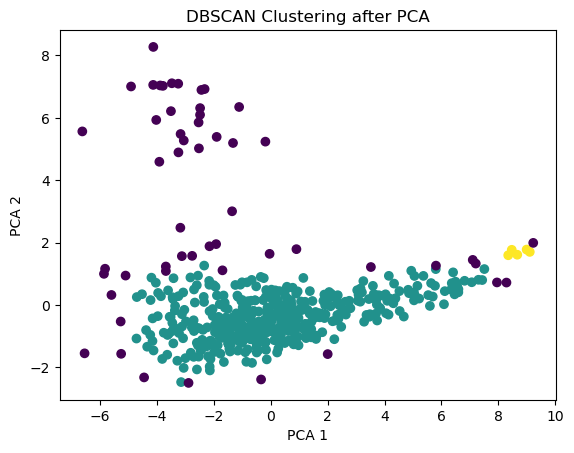

Silhouette Score: 0.3929752973482768


In [365]:
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters = dbscan.fit_predict(X_pca)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis')
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("DBSCAN Clustering after PCA")
plt.show()

print(f"Silhouette Score: {silhouette_score(X_pca, clusters)}")

Now we need to tune the hyperparameters to see if we can raise our silhouette score. The following function is adapted from lecture notes [@noauthor_course_nodate]

In [369]:
def maximize_silhouette(X,algo="ag",nmax=20,i_plot=False):
    X=np.ascontiguousarray(X)
    print(X.shape)

    params=[]; sil_scores=[]
    sil_max=-10

    for param in range(2,nmax+1):
        if(algo=="ag"):
            model = sklearn.cluster.AgglomerativeClustering(n_clusters=param).fit(X)
            labels=model.labels_

        if(algo=="dbscan"):
            param=0.25*(param-1)
            model = sklearn.cluster.DBSCAN(eps=param).fit(X)
            labels=model.labels_

        try:
            sil_scores.append(sklearn.metrics.silhouette_score(X,labels))
            params.append(param)
        except:
            continue

        if(sil_scores[-1]>sil_max):
             opt_param=param
             sil_max=sil_scores[-1]
             opt_labels=labels

    print("OPTIMAL PARAMETER =",opt_param)

    if(i_plot):
        fig, ax = plt.subplots()
        ax.plot(params, sil_scores, "-o")
        ax.set(xlabel='Hyper-parameter', ylabel='Silhouette')
        plt.show()

    return opt_labels

(501, 2)
OPTIMAL PARAMETER = 1.5


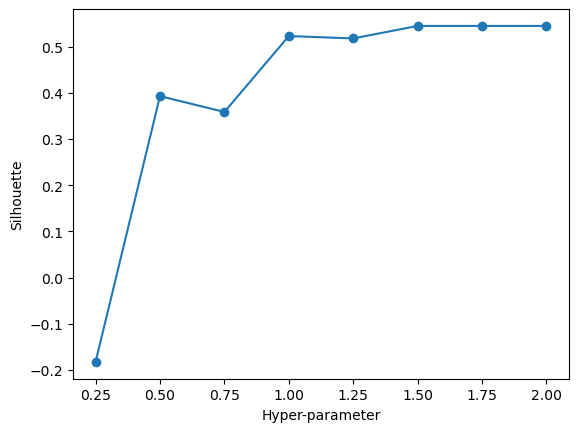

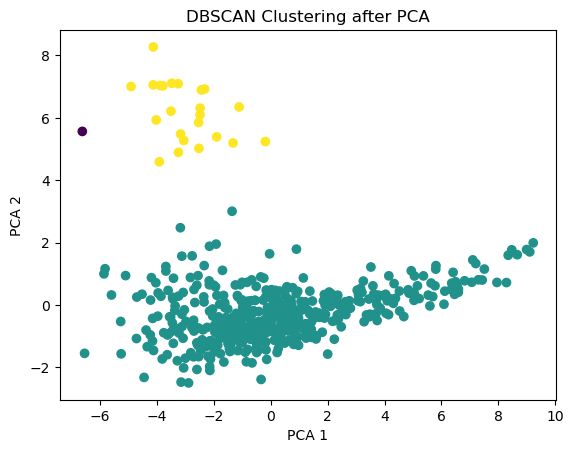

Silhouette Score: 0.5450321295485361


In [376]:
opt_labels=maximize_silhouette(X_pca,algo="dbscan",nmax=15, i_plot=True)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=opt_labels, cmap='viridis')
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("DBSCAN Clustering after PCA")
plt.show()

print(f"Silhouette Score: {silhouette_score(X_pca, opt_labels)}")

**Results:** After tuning the hyperparameters, we observe better separability among our clusters, with a silhouette score of 0.54. This performance exceeds that of the original DBSCAN and K-means clustering results. However, one limitation is that most schools are grouped into a single large cluster. Despite this, there is a smaller cluster that might be capturing schools with similar outcomes. The lone purple dot likely represents noise or an outlier.

## Hierarchical Clustering

Hierarchical clustering is a clustering technique that builds a tree-like structure of clusters to organize our data. It does this in two ways:
- Agglomerative: A bottom up approach where each observation starts as its own cluster and is merged with others as it moves up the hierarchy
- Divisive: A top down approach where all data points start in one cluster, and are split recursively as you go down the hierarchy

The agglomerative approach is more commonly used, so we will apply this method to the PCA-reduced data. Unlike kmeans, hierarchical clustering doesn't require us to specify a k number of clusters. It can be more flexible. We will visualize it with a dendogram to show insights into its structure.

(501, 2)
OPTIMAL PARAMETER = 3


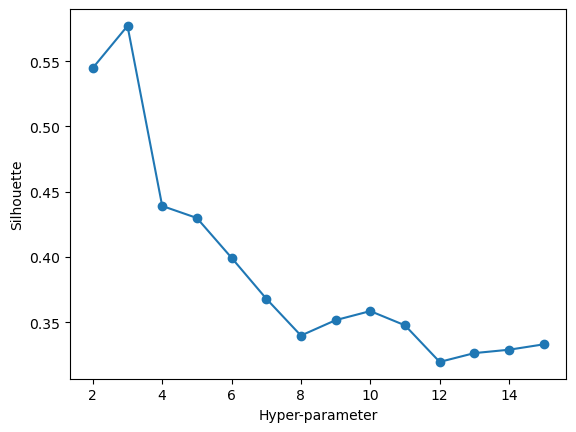

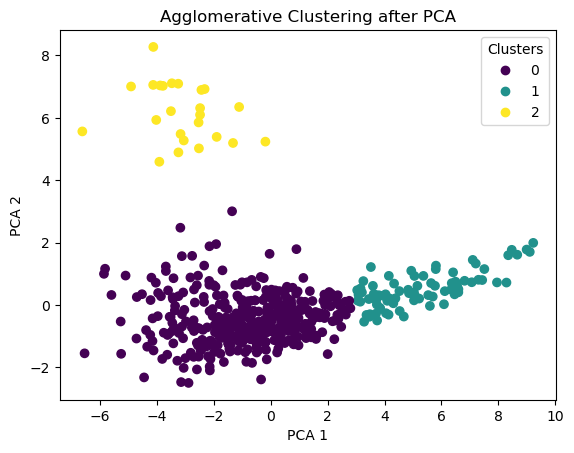

Silhouette Score: 0.5769711294126749


In [401]:
opt_labels=maximize_silhouette(X_pca,algo="ag",nmax=15, i_plot=True)

scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=opt_labels, cmap='viridis')
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Agglomerative Clustering after PCA")
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.show()

print(f"Silhouette Score: {silhouette_score(X_pca, opt_labels)}")

Now we can add clusters back to dataframe and visualize how our target variables appear in each cluster

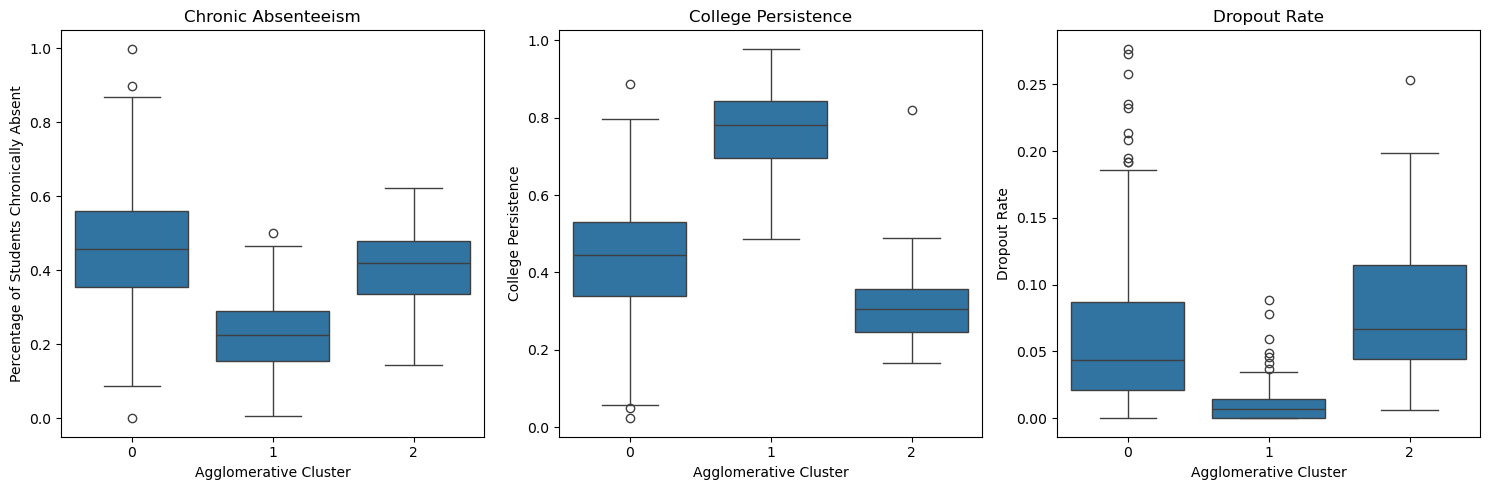

In [425]:
df_subset['Agglomerative_Cluster'] = opt_labels

df_subset['dropout'] = np.exp(df_subset['log_dropout_rate']) - 1

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.boxplot(data=df_subset, x='Agglomerative_Cluster', y='Percent of Students Chronically Absent', ax=axes[0])
sns.boxplot(data=df_subset, x='Agglomerative_Cluster', y='Metric Value - College Persistence', ax=axes[1])
sns.boxplot(data=df_subset, x='Agglomerative_Cluster', y='dropout', ax=axes[2])

axes[0].set_title('Chronic Absenteeism')
axes[1].set_title('College Persistence')
axes[2].set_title('Dropout Rate')

axes[0].set_ylabel('Percentage of Students Chronically Absent')
axes[1].set_ylabel('College Persistence')
axes[2].set_ylabel('Dropout Rate')

axes[0].set_xlabel('Agglomerative Cluster')
axes[1].set_xlabel('Agglomerative Cluster')
axes[2].set_xlabel('Agglomerative Cluster')

plt.tight_layout()
plt.show()

[@gpt4o_code_gen]

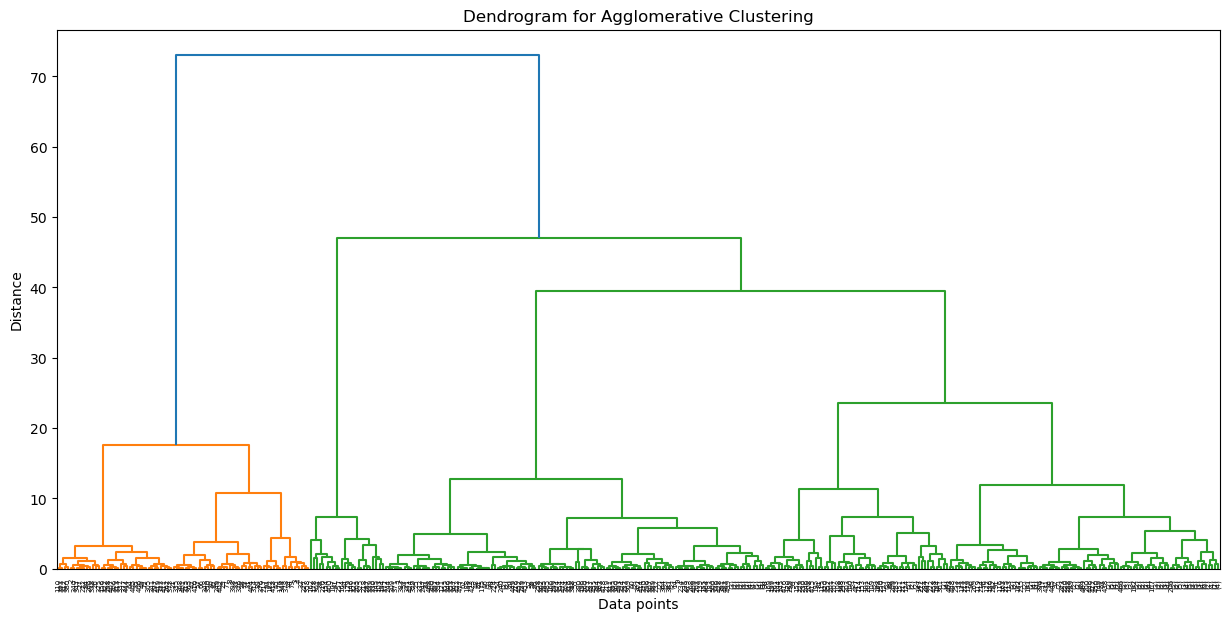

In [431]:
Z = linkage(X_pca, 'ward')

plt.figure(figsize=(15, 7))
dendrogram(Z, truncate_mode='level', p=10)
plt.title('Dendrogram for Agglomerative Clustering')
plt.xlabel('Data points')
plt.ylabel('Distance')
plt.show()

**Results:** The Agglomerative Clustering algorithm achieved the highest silhouette score among the clustering methods we tested. In addition, it is clear that Cluster 1 contains schools with the best student outcomes, with the lowest chronic absenteeism, lowest dropout rates, and highest college persistence. This indicates that the algorithm successfully identified meaningful patterns in the data, emphasizing the impact of these features on school outcomes. By examining the qualities and socioeconomic factors associated with the schools in this cluster, we can gain insights into the key drivers of success in these public high schools. In addition, the dendogram helps us visualize how the schools are grouped at different levels of similarity and the hierarchical relationships between them.

### Conclusion

I applied various clustering techniques and dimensionality reduction methods, and was able to identify key patterns in the school data. PCA revealed that three components explained most of the variance, with a relationship between dropout rates and principal components. t-SNE uncovered distinct groups of schools based on college persistence at the local level but struggled with global separation at higher perplexity values.

K-means clustering was able to highlight schools with socioeconomic challenges but was not able to clearly separate the clusters. After tuning DBSCAN, we saw a bit better separability, but most schools were in one large cluster. Agglomerative Clustering, had the highest silhouette score, and was able to identify schools with the best outcomes, shown by the our targets like chronic absenteeism, dropout rates, and college persistence. The dendrogram also provided insight into the hierarchical relationships between schools.

Overall, Agglomerative Clustering provided the most meaningful insights, emphasizing the ability of my features to predict school success.